In [1]:
import pandas as pd
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import math
from functools import reduce
import matplotlib 
import gpplot as gpp 
#gpp.set_aesthetics(context = 'paper')


plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Arial'
})


In [2]:
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)


Pandas version: 2.0.3
Numpy version: 1.24.4


In [3]:
inPath = "../Data/PrimaryLibrary/processed_z_score/"
merged_df = pd.read_csv(inPath + "inHouseDatasetsCombined.csv")

# Gene level analysis

In [4]:
def averaged_gene_z_scores_single_column(genes, z_scores):
    gene_scores = {}
    combined_scores = {}

    # Group z-scores by gene
    for gene, score in zip(genes, z_scores):
        if gene in gene_scores:
            gene_scores[gene].append(score)
        else:
            gene_scores[gene] = [score]

    # Calculate combined z-scores for each gene
    for gene, scores in gene_scores.items():
        combined_score = np.sum(scores) / len(scores)
        combined_scores[gene] = combined_score

    return combined_scores



In [5]:
# Calculate average z-scores and save it into dict
combined_gene_z_scores_A549_Zim3 = averaged_gene_z_scores_single_column(merged_df['Target Gene Symbol'], 
                                                                      merged_df['z_scored_avg_lfc_A549_Zim3'])
combined_gene_z_scores_A549_Kox1 = averaged_gene_z_scores_single_column(merged_df['Target Gene Symbol'], 
                                                                      merged_df['z_scored_avg_lfc_A549_Kox1'])
combined_gene_z_scores_HCT116_Zim3 = averaged_gene_z_scores_single_column(merged_df['Target Gene Symbol'], 
                                                                      merged_df['z_scored_avg_lfc_HCT116_Zim3'])
combined_gene_z_scores_HCT116_Kox1 = averaged_gene_z_scores_single_column(merged_df['Target Gene Symbol'], 
                                                                      merged_df['z_scored_avg_lfc_HCT116_Kox1'])


# translate dict into dataframe
combined_gene_z_scores_A549_Zim3 = pd.DataFrame(combined_gene_z_scores_A549_Zim3.items(), columns=['Target Gene Symbol', 'z_scored_avg_lfc_A549_Zim3'])             
combined_gene_z_scores_A549_Kox1 = pd.DataFrame(combined_gene_z_scores_A549_Kox1.items(), columns=['Target Gene Symbol', 'z_scored_avg_lfc_A549_Kox1'])             
combined_gene_z_scores_HCT116_Zim3 = pd.DataFrame(combined_gene_z_scores_HCT116_Zim3.items(), columns=['Target Gene Symbol', 'z_scored_avg_lfc_HCT116_Zim3'])             
combined_gene_z_scores_HCT116_Kox1 = pd.DataFrame(combined_gene_z_scores_HCT116_Kox1.items(), columns=['Target Gene Symbol', 'z_scored_avg_lfc_HCT116_Kox1'])             

# combine averaged z-scores for all the domains and cell lines
combined_gene_z_scores = reduce(lambda left, right: pd.merge(left, right, on='Target Gene Symbol', how='inner'), 
                                [combined_gene_z_scores_A549_Zim3, combined_gene_z_scores_A549_Kox1, combined_gene_z_scores_HCT116_Zim3, combined_gene_z_scores_HCT116_Kox1])
             
combined_gene_z_scores.head()      

,Target Gene Symbol,z_scored_avg_lfc_A549_Zim3,z_scored_avg_lfc_A549_Kox1,z_scored_avg_lfc_HCT116_Zim3,z_scored_avg_lfc_HCT116_Kox1
0,OR6K6,0.264249,0.093926,0.116008,0.125713
1,COPS3,-1.118453,-0.863480,-1.242961,-1.414997
2,RSRC2,-0.361538,-0.290034,-1.687318,-1.788140
3,ADSL,-1.354587,-0.795711,-1.972559,-2.318961
4,CYP7A1,-0.013117,-0.058952,-0.097697,0.117889


In [6]:
combined_gene_z_scores = pd.merge(merged_df[['Target Gene Symbol','Category']].drop_duplicates(), 
         combined_gene_z_scores, 
         on = 'Target Gene Symbol', how = 'right')
# Create a new column for each existing column to store ranks
for column in ['z_scored_avg_lfc_A549_Zim3',
       'z_scored_avg_lfc_A549_Kox1', 'z_scored_avg_lfc_HCT116_Zim3',
       'z_scored_avg_lfc_HCT116_Kox1']:
    combined_gene_z_scores[column + "_Rank"] = combined_gene_z_scores[column].rank(method='average', ascending=True)


# overlap of the genes in top 100 for all combination
combined_gene_z_scores_a549_100 = combined_gene_z_scores[(combined_gene_z_scores['z_scored_avg_lfc_A549_Zim3_Rank'] <= 100) & 
                       (combined_gene_z_scores['z_scored_avg_lfc_A549_Kox1_Rank'] <= 100)]
combined_gene_z_scores_HCT116_100 = combined_gene_z_scores[(combined_gene_z_scores['z_scored_avg_lfc_HCT116_Zim3_Rank'] <= 100) & 
                       (combined_gene_z_scores['z_scored_avg_lfc_HCT116_Kox1_Rank'] <= 100)]
combined_gene_z_scores_Zim3_100 = combined_gene_z_scores[(combined_gene_z_scores['z_scored_avg_lfc_HCT116_Zim3_Rank'] <= 100) & 
                       (combined_gene_z_scores['z_scored_avg_lfc_A549_Zim3_Rank'] <= 100)]
combined_gene_z_scores_Kox1_100 = combined_gene_z_scores[(combined_gene_z_scores['z_scored_avg_lfc_HCT116_Kox1_Rank'] <= 100) & 
                       (combined_gene_z_scores['z_scored_avg_lfc_A549_Kox1_Rank'] <= 100)]

print(len(combined_gene_z_scores_a549_100), 
      len(combined_gene_z_scores_HCT116_100),
     len(combined_gene_z_scores_Kox1_100),
      len(combined_gene_z_scores_Zim3_100)
     )

combined_gene_z_scores.head()

65 84 53 60


,Target Gene Symbol,Category,z_scored_avg_lfc_A549_Zim3,z_scored_avg_lfc_A549_Kox1,z_scored_avg_lfc_HCT116_Zim3,z_scored_avg_lfc_HCT116_Kox1,z_scored_avg_lfc_A549_Zim3_Rank,z_scored_avg_lfc_A549_Kox1_Rank,z_scored_avg_lfc_HCT116_Zim3_Rank,z_scored_avg_lfc_HCT116_Kox1_Rank
0,OR6K6,Non-essential,0.264249,0.093926,0.116008,0.125713,1782.0,1554.0,1628.0,1617.0
1,COPS3,Essential,-1.118453,-0.863480,-1.242961,-1.414997,407.0,555.0,359.0,272.0
2,RSRC2,Essential,-0.361538,-0.290034,-1.687318,-1.788140,995.0,1043.0,211.0,175.0
3,ADSL,Essential,-1.354587,-0.795711,-1.972559,-2.318961,286.0,603.0,136.0,113.0
4,CYP7A1,Non-essential,-0.013117,-0.058952,-0.097697,0.117889,1420.0,1332.0,1352.0,1604.0


In [7]:
combined_gene_z_scores.to_csv("../Data/PrimaryLibrary/processed_z_score/GeneZscore_average.csv")

# pairwise scatter plot on a gene level (includes control)


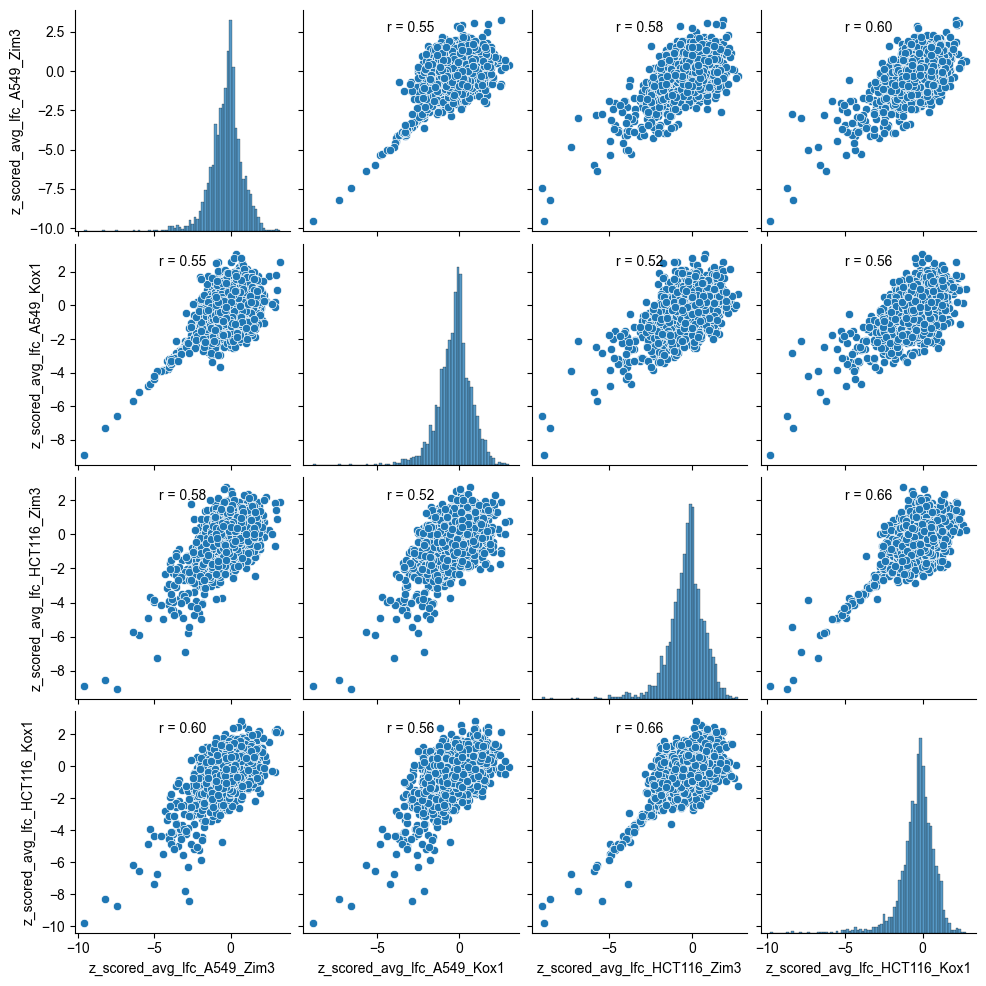

In [8]:

pairplot_df = combined_gene_z_scores[['z_scored_avg_lfc_A549_Zim3', 'z_scored_avg_lfc_A549_Kox1', 'z_scored_avg_lfc_HCT116_Zim3', 'z_scored_avg_lfc_HCT116_Kox1']]

# Scatter plot with Pearson correlation
pairplot = sns.pairplot(pairplot_df)

# Adding Pearson correlation on each plot
for i in range(len(pairplot_df.columns)):
    for j in range(len(pairplot_df.columns)):
        if i != j:
            # Calculate Pearson correlation
            corr = pairplot_df.iloc[:, i].corr(pairplot_df.iloc[:, j])
            pairplot.axes[j, i].annotate(f'r = {corr:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center')

plt.show()

# pairwise scatter plot on a gene level (without control)

In [9]:
# only genes information no controls
selected_combined_gene_z_scores = combined_gene_z_scores[~combined_gene_z_scores['Target Gene Symbol'].str.startswith('NO_SITE') & \
                                                         ~combined_gene_z_scores['Target Gene Symbol'].str.startswith('ONE_INTERGENIC')]


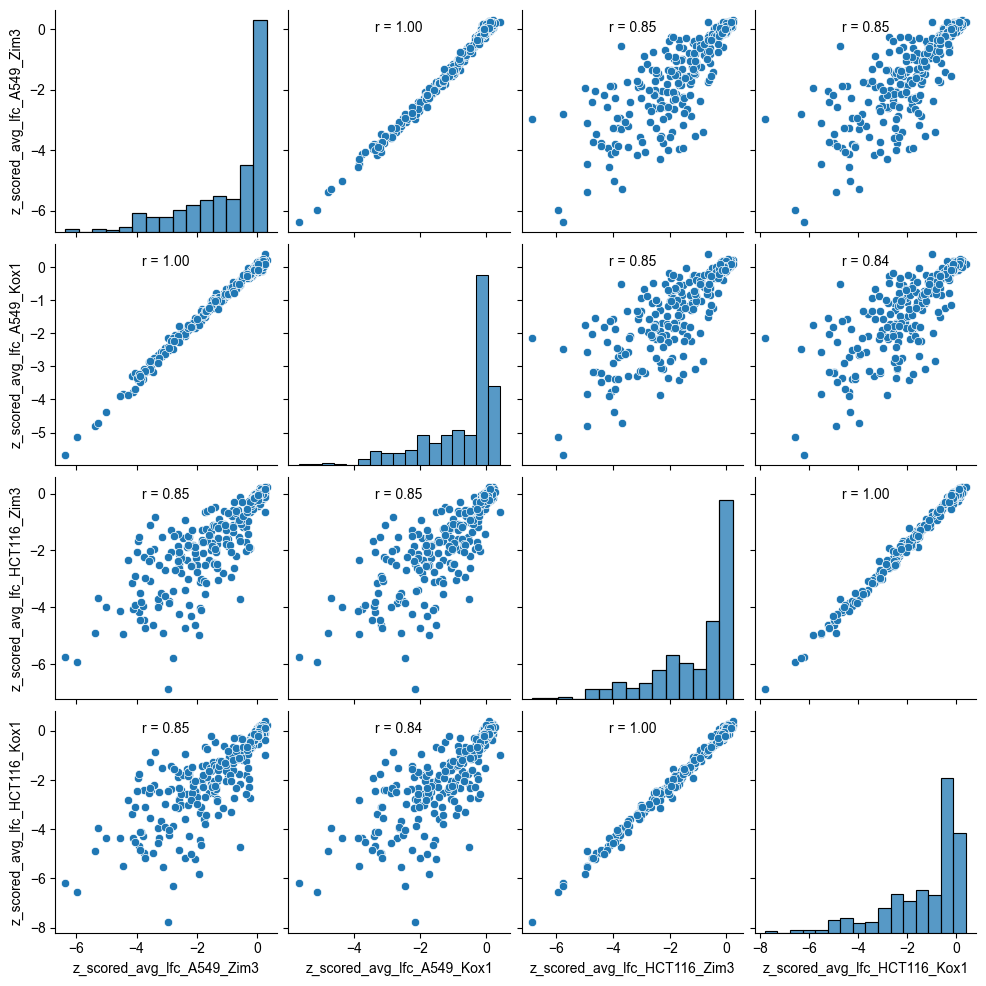

In [10]:
# pairwise scatter plot on a gene level

pairplot_df = selected_combined_gene_z_scores[['z_scored_avg_lfc_A549_Zim3', 'z_scored_avg_lfc_A549_Kox1', 'z_scored_avg_lfc_HCT116_Zim3', 'z_scored_avg_lfc_HCT116_Kox1']]

# Scatter plot with Pearson correlation
pairplot = sns.pairplot(pairplot_df)

# Adding Pearson correlation on each plot
for i in range(len(pairplot_df.columns)):
    for j in range(len(pairplot_df.columns)):
        if i != j:
            # Calculate Pearson correlation
            corr = pairplot_df.iloc[:, i].corr(pairplot_df.iloc[:, j])
            pairplot.axes[j, i].annotate(f'r = {corr:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center')

plt.show()

In [11]:
selected_combined_gene_z_scores

,Target Gene Symbol,Category,z_scored_avg_lfc_A549_Zim3,z_scored_avg_lfc_A549_Kox1,z_scored_avg_lfc_HCT116_Zim3,z_scored_avg_lfc_HCT116_Kox1,z_scored_avg_lfc_A549_Zim3_Rank,z_scored_avg_lfc_A549_Kox1_Rank,z_scored_avg_lfc_HCT116_Zim3_Rank,z_scored_avg_lfc_HCT116_Kox1_Rank
0,OR6K6,Non-essential,0.264249,0.093926,0.116008,0.125713,1782.0,1554.0,1628.0,1617.0
1,COPS3,Essential,-1.118453,-0.863480,-1.242961,-1.414997,407.0,555.0,359.0,272.0
2,RSRC2,Essential,-0.361538,-0.290034,-1.687318,-1.788140,995.0,1043.0,211.0,175.0
3,ADSL,Essential,-1.354587,-0.795711,-1.972559,-2.318961,286.0,603.0,136.0,113.0
4,CYP7A1,Non-essential,-0.013117,-0.058952,-0.097697,0.117889,1420.0,1332.0,1352.0,1604.0
...,...,...,...,...,...,...,...,...,...,...
452,CT45A3,Non-essential,-0.477645,-0.224179,-0.803430,-0.651282,898.0,1118.0,628.0,736.0
454,PIGS,Essential,-0.760102,-0.796219,-0.294197,-0.286398,646.0,602.0,1087.0,1095.0
456,TEDC1,Essential,-0.354501,-0.207945,-0.662738,-0.765367,1003.0,1135.0,740.0,635.0
462,INS,Non-essential,0.011048,-0.076516,-0.043887,-0.220821,1457.0,1299.0,1419.0,1178.0


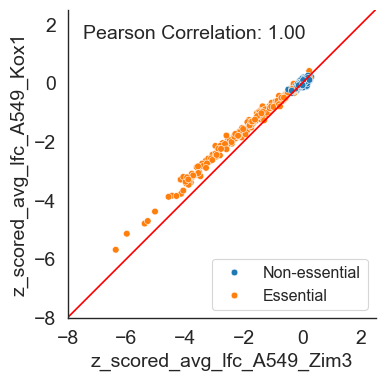

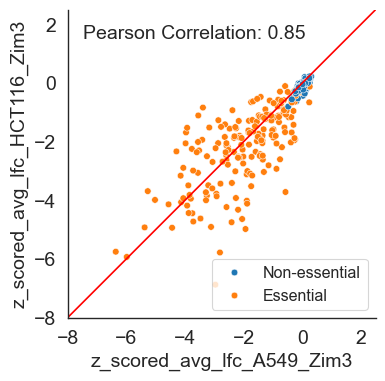

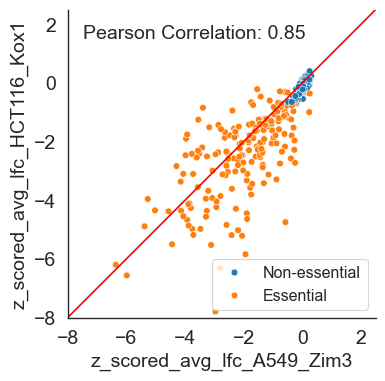

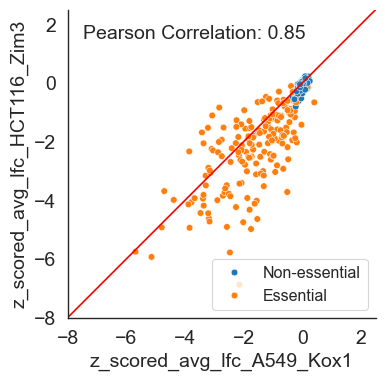

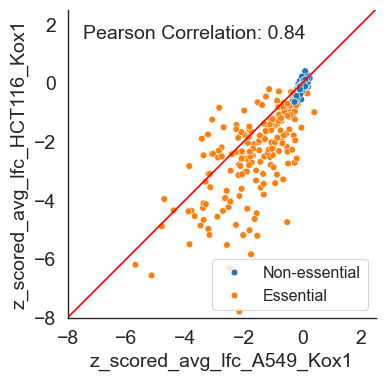

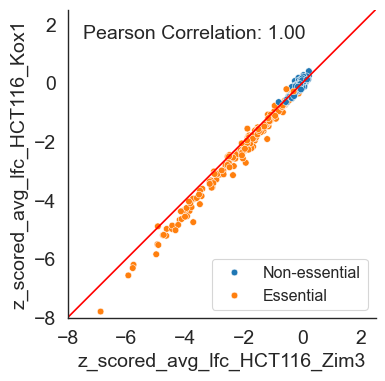

In [12]:
# Create a plot to test
sns.set_style("white")
sns.set_context("paper")
#plt.switch_backend('svg')
figure1_outpath = '../Figure/Figure 1/Individual Figures/'

# List of all columns to plot
columns = ['z_scored_avg_lfc_A549_Zim3', 'z_scored_avg_lfc_A549_Kox1', 'z_scored_avg_lfc_HCT116_Zim3', 'z_scored_avg_lfc_HCT116_Kox1']
version = '2'

# Create scatter plots for each pair
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        plt.figure(figsize=(4, 4))
        ax = sns.scatterplot(x=columns[i], y=columns[j], data=selected_combined_gene_z_scores, hue = 'Category')
        sns.despine()
        # Calculate the Pearson correlation
        corr = selected_combined_gene_z_scores[[columns[i], columns[j]]].corr(method = 'pearson').iloc[0, 1]
        
        # Plot title with correlation
        plt.text(0.05, 0.95, f'Pearson Correlation: {corr:.2f}', ha='left', va='top', transform=plt.gca().transAxes, fontsize=14)

        #plt.title(f'Scatter Plot of {columns[i]} vs {columns[j]} (Pearson Correlation: {corr:.2f})')
        plt.xlabel(columns[i], fontsize=14)
        plt.ylabel(columns[j], fontsize=14)
        # Save the figure to desktop
        figure_name = f'Scatter_{columns[i]}_vs_{columns[j]}_v{version}.pdf'#pdf
       
        plt.legend(loc='lower right', fontsize='large')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.set_xlim(-8, 2.5)
#        ax.set_xlim(-110, 20)
        ax.set_ylim(-8, 2.5)
#        ax.set_ylim(-110, 20)
        ax.set_aspect('equal')
        ax.plot([0,1],[0,1], transform=ax.transAxes,color = 'red')
        plt.savefig(figure1_outpath + figure_name, format='pdf', dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.1)


        #plt.show()


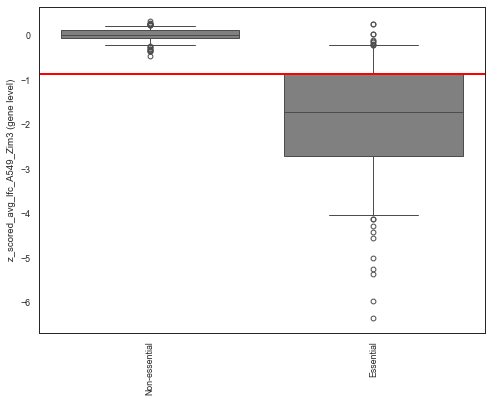

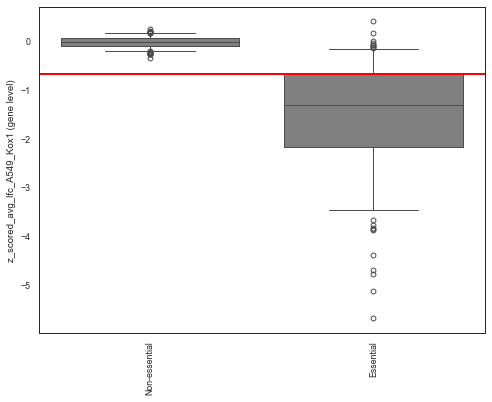

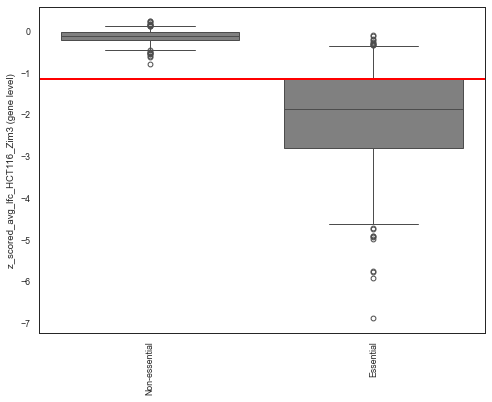

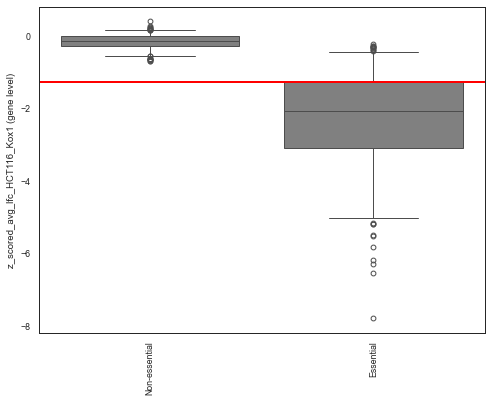

In [13]:
for phenotype in columns:
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(data = selected_combined_gene_z_scores, x ='Category', y=phenotype,
                order=['Non-essential', 'Essential'], color = 'grey', whis=[5, 95])
    plt.xlabel('')
    y_label = phenotype + ' (gene level)'
    plt.ylabel(y_label)
    plt.xticks(rotation=90)
    ax.axhline(y=selected_combined_gene_z_scores[selected_combined_gene_z_scores.Category.isin([ 'Essential'])][phenotype].quantile([0.75]).item(),
           linewidth=2, color='red', ls='-')

    plt.savefig(figure1_outpath + y_label + '_boxplot.pdf', dpi=300, bbox_inches='tight')

    plt.show()

